# Just Have to be Faster Than You

Suppose you are a student at university and there is a local watering hole with a phenomenal happy hour. This is, however, no ordinary happy hour. Drinks are not just discounted, but free... in the beginning. Once the happy hour begins, the first person to get a drink gets it for free, but then the clock starts. Every additional second increments the price of a drink by 1 pence.

$$p_{t=0}=0, p_{t=1}=1, p_{t=2}=2, \dots, p_{t=T}=T$$

Being a university student, you are quite sensitive to price so it pays to the bartender as close the $t=0$ as possible. Unfortunately, there are quite a few price sensitive university students. To deal with this, management has decided (rather recklessly) that all contenders for the first drink must race to the bar starting from down the block. That is, one cannot be the first at the bar by just arriving early. To make matters worse, drinks are not ready and waiting to be served. Each is crafted with care, but the clock runs the whole time.

How might we reason about the expected cost of your drink?

In [6]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

%matplotlib inline

## Mechanics of Drink Retrieval

To understand how much your drink is going to cost ($p$), we'll need to understand where you sit in the queue that forms, position $n \geq 0$. That position will depend on your arrival time $t$ and the arrival rate of the competing population of thirsty students $r$. The cost will then be a function of the drink crafting rate the bartender can deliver $c$ and your position $n$. 

Let's give this some structure so we can build a model that reflects the mechanics of the situation. All of the parameters in $\color{blue}{\text{blue}}$ are model inputs and will require [priors](https://bayesiancomputationbook.com/markdown/chp_01.html#id6). The remaining parameters in $\color{orange}{\text{orange}}$ are derived. First, we will assume that the distance of the race is fixed. Given your running ability, we can focus on modeling the time directly. Let us assume your ability to get to the bar tends to cluster around the same time, which we will model with a normal distribution.

$$\color{orange}{t} \sim N(\color{blue}{\mu_t}, \color{blue}{\sigma_t})$$

The competing population can be conceived of as a collection of folks that have different running speeds, but largely arrive one at a time at an average rate of $r$. The amount of people in line by the time you get there $n$ is a function of the arrival rate $r$ and your arriveal time $t$. With countable processes, it is helpful to model the number of events that occur in a fixed interval in time by way of a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution). The events in this case are the arrivals of competing students.

$$\color{orange}{n} \sim Pois(\color{blue}{r}, \color{orange}{t})$$

Finally, while the bartender is a professional, they do not make drinks in exactly the same amount of time for each order. We will also model this process as normally distributed.

$$\color{orange}{c} \sim N(\color{blue}{\mu_c}, \color{blue}{\sigma_c})$$

For our purposes, we will assume that the ordering rate is negligble, so orders are submitted as soon as the first student arrives or the preceding student receives a drink. Finally, the price of your drink is not stochastic, but deterministic. It is constructed directly from the time it takes all students in front of you to be served.

$$p = \color{orange}{n}\color{orange}{c}$$

Even though $p$ is directly computed, the random nature of the inputs to that calculation will generate a range of possible values for $p$. We can directly encode this model using [pymc](https://www.pymc.io/welcome.html).

In [7]:
with pm.Model() as price_m:
    
    # Priors
    mu_t = pm.Normal("mu_t", mu=25, sigma=3)
    sigma_t = pm.Uniform('sigma_t', lower=0, upper=5)
    r = pm.Normal("r", mu=2, sigma=0.5)
    mu_c = pm.Normal("mu_c", mu=5, sigma=1)
    sigma_c = pm.Uniform('sigma_c', lower=0, upper=2)
    
    # Model
    t = pm.Normal("t", mu=mu_t, sigma=sigma_t)
    n = pm.Poisson("n", mu=r*t)
    c = pm.Normal("c", mu=mu_c, sigma=sigma_c)
    p = pm.Deterministic("p", n*c)

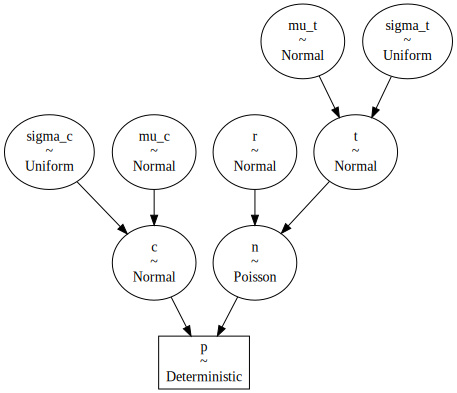

In [8]:
pm.model_to_graphviz(price_m)

In [9]:
pm.sample_prior_predictive(1000, price_m)

Sampling: [c, mu_c, mu_t, n, r, sigma_c, sigma_t, t]


Inference data with groups:
	> prior

Sampling: [c, mu_c, mu_t, n, r, sigma_c, sigma_t, t]


array([[<AxesSubplot: title={'center': 'n'}>,
        <AxesSubplot: title={'center': 'sigma_c'}>,
        <AxesSubplot: title={'center': 'r'}>],
       [<AxesSubplot: title={'center': 'c'}>,
        <AxesSubplot: title={'center': 'mu_t'}>,
        <AxesSubplot: title={'center': 'sigma_t'}>],
       [<AxesSubplot: title={'center': 't'}>,
        <AxesSubplot: title={'center': 'mu_c'}>,
        <AxesSubplot: title={'center': 'p'}>]], dtype=object)

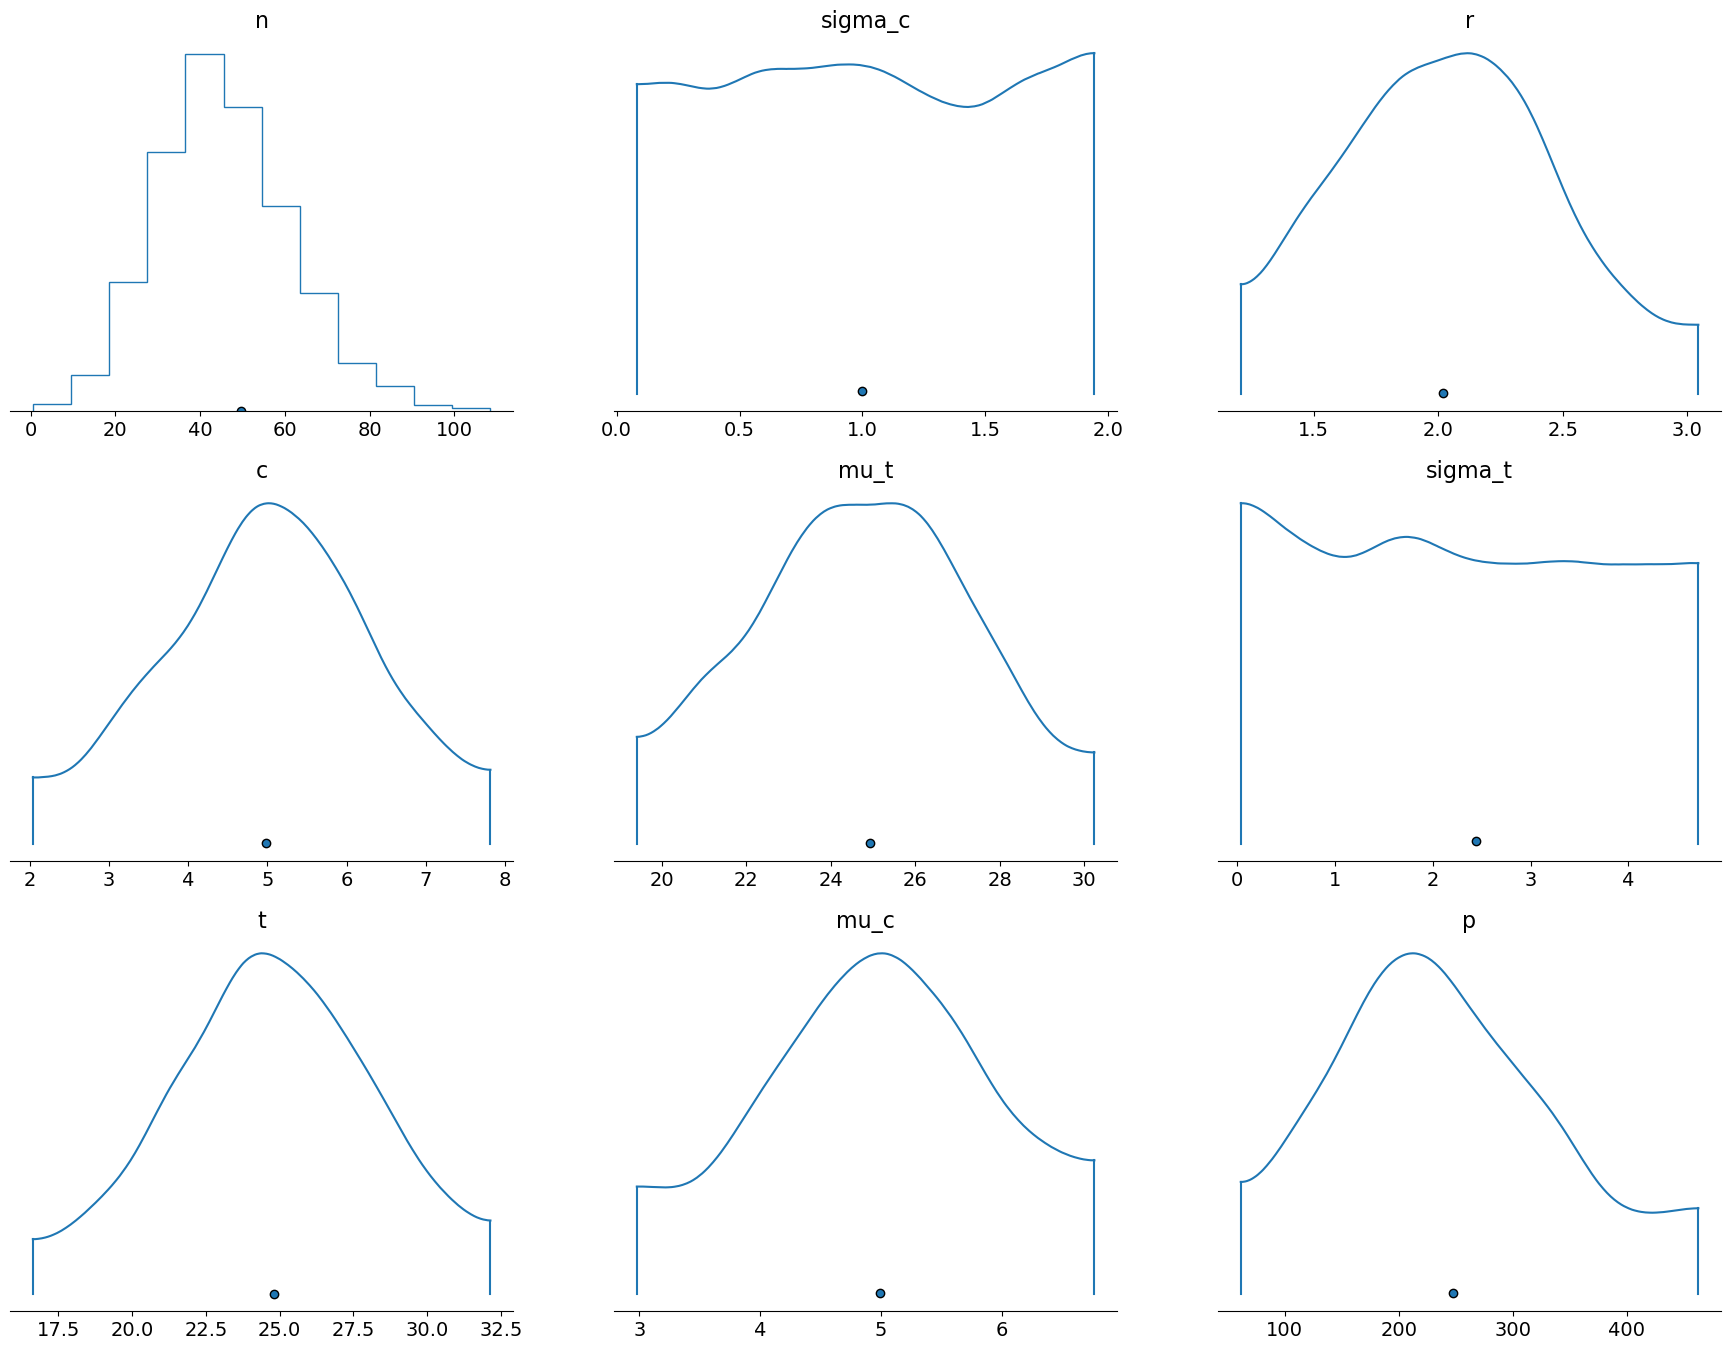

In [10]:
az.plot_density([pm.sample_prior_predictive(1000, price_m)["prior"]])